In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
from annotation_dset import annotationDatabase
import pickle as pkl
from os.path import join as oj
import seaborn as sns
import viz
import style

## useful constants
ANNOTATIONS_DIR = '../data/Octets/annotations' # path to many datasets, includes on directory before the below dirs
LABELS_FILE = '/annotation-tool/data.json'
OUT_MANIFEST_FILE = '/manifests/output/output.manifest'
WORKERS_RESPONSE = '/annotations/worker-response'
IMAGE_PATH = '../data/Octets/images' # location of images
OUTPUT_PDF_DIR = './figures' # location of output pdfs
SEQUENCE_LENGTH = 10 # number of images per sequence
PROCESSED_DIR = 'processed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Get list of experiments in annotation dir. Alternatively, specify ones you care about.
annotations_dict = {}
annotations_names_dict = {}
experiments = [os.path.split(f)[1] for f in glob.glob(os.path.join(ANNOTATIONS_DIR, '*'))]
print('experiments', experiments)
# experiments = ['calibration-random-v2-facial-hair-000'] #'perona-causal-faces-uncanny-000']

# If output directory doesn't exist, make it
if not os.path.exists(OUTPUT_PDF_DIR):
    os.makedirs(OUTPUT_PDF_DIR)

# Do analysis figures for each experiment
for EXPERIMENT_LABEL in experiments:
    ANNOTATIONS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{WORKERS_RESPONSE}'
    OUT_MANIFEST_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{OUT_MANIFEST_FILE}'
    LABELS_PATH = f'{ANNOTATIONS_DIR}/{EXPERIMENT_LABEL}{LABELS_FILE}'
    OUT_PDF_FILE_NAME = os.path.join(OUTPUT_PDF_DIR, EXPERIMENT_LABEL + '.pdf')

    #Read labels using annotation-tool/data.json and assign integers to labels 
    with open(LABELS_PATH, 'r') as labels_file:
        labels_data = json.load(labels_file)['labels']
        LABELS = [l['label'] for l in labels_data]
    labelScores = {l:i for (i, l) in enumerate(LABELS)} # generate numerical scores for the labels - useful in regression

    # Get ordered list of image names from output manifest
    image_names = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            image_names.append(name)

    # Make map from annotation index to image index
    idx_map = []
    with jsonlines.open(OUT_MANIFEST_PATH) as reader:
        for obj in reader:
            _, name = os.path.split(obj['source-ref']) #remove leading path
            idx = name.split('.')[0]
            idx_map.append(idx)
  

    # Make annotation file name list in proper order
#     annotation_file_names = []
#     for i in range(len(idx_map)):
#         idx = idx_map.index(str(i))
#         annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% idx)    
        
        
    # Make annotation file name list in proper order (keep same order)
    annotation_file_names = []
    for i in range(len(idx_map)):
        annotation_file_names += glob.glob(ANNOTATIONS_PATH + '/*/%d/*.json'% i)

        
    # put together the database of the annotator IDs and their work
    annotations = annotationDatabase(annotation_file_names, labelScores)
    annotations.startPDFReport(OUT_PDF_FILE_NAME, EXPERIMENT_LABEL)
    annotations.displayAnnotatorsWork()
    annotations.displaySequenceAnnotations(image_names, LABELS, SEQUENCE_LENGTH, IMAGE_PATH)
    annotations.endPDFReport()
    
    print(LABELS, np.array(annotations.imageScores).shape)
    annotations_dict[EXPERIMENT_LABEL] = np.array(annotations.imageScores)
    annotations_names_dict[EXPERIMENT_LABEL] = LABELS

pkl.dump(annotations_dict, open(oj(PROCESSED_DIR, '05_annotations_dict.pkl'), 'wb'))
pkl.dump(annotations_names_dict,
         open(oj(PROCESSED_DIR, '05_annotations_labels_dict.pkl'), 'wb'))
print('saved!')

# look at the annotations

In [3]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '05_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '05_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('perona-causal-faces-', '').replace('-015', '').replace('-15', ''): annotations_dict[k]
                    for k in annotations_dict}

In [4]:
annotations_dict.keys()

dict_keys(['facial-hair', 'hair-length', 'uncanny', 'gender', 'age', 'makeup', 'ethnicity', 'smile', 'skin-color'])

In [5]:
# transects for skin color, hair length, and gender
attrs = ['skin-color', 'hair-length', 'gender', 'uncanny', 'age', 'makeup', 'ethnicity', 'smile', 'facial-hair']
N = len(attrs)
annotations_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in attrs])

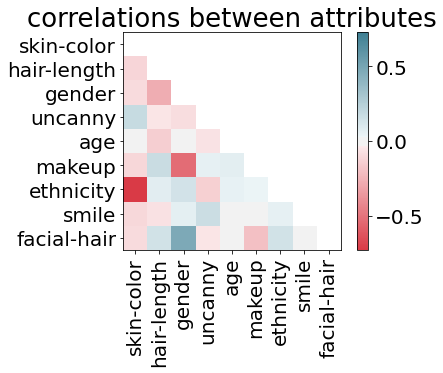

In [6]:
viz.corrplot(np.corrcoef(annotations_mat))
plt.xticks(range(N), attrs, rotation='vertical')
plt.title('correlations between attributes')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()

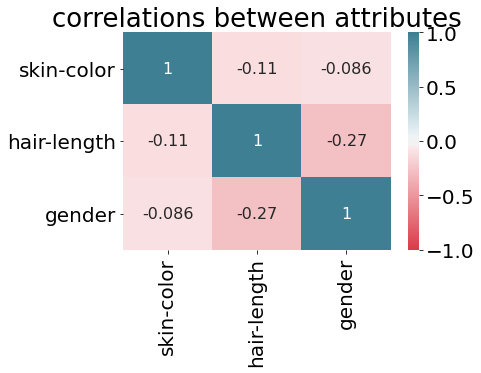

In [15]:
# viz.corrplot(np.corrcoef(annotations_mat)[:3, :3])
sns.heatmap(np.corrcoef(annotations_mat)[:3, :3], 
            annot=True, cmap=style.cmap_div, vmin=-1, vmax=1)
plt.xticks(np.arange(N)[:3] + 0.5, attrs[:3], rotation='vertical')
plt.title('correlations between attributes')
plt.yticks(np.arange(N)[:3] + 0.5, attrs[:3], rotation='horizontal')
# plt.colorbar()
plt.show()

In [17]:
print(attrs)
annotations_mat

['skin-color', 'hair-length', 'gender', 'uncanny', 'age', 'makeup', 'ethnicity', 'smile', 'facial-hair']


array([[0.6, 0. , 0.2, ..., 3.8, 4.2, 3.6],
       [1. , 1. , 1.6, ..., 0.6, 2. , 1.8],
       [2.2, 4. , 0.2, ..., 3.2, 1. , 3.6],
       ...,
       [4.6, 5. , 3.8, ..., 2. , 2.2, 2.8],
       [2.4, 2.2, 2. , ..., 1. , 0.8, 0.8],
       [0. , 0.4, 0.2, ..., 1.2, 0. , 1.6]])